# Viewing and manipulating FITS images

## Authors
Lia Corrales, Kris Stern, Stephanie T. Douglas, Kelle Cruz, Lúthien Liu, Zihao Chen, Saima Siddiqui

## Learning Goals
1. Open FITS files and load image data
2. Make a 2D histogram with image data
3. Stack several images into a single image
4. Write image data to a FITS file

## Companion Content

* This link provides a comprehensive description of FITS file usage in this tutorial: [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html) 

## Keywords
FITS, file input/output, image manipulation, numpy, matplotlib, histogram, colorbar

## Summary

This tutorial demonstrates the use of `astropy.utils.data` to download a data file, then uses `astropy.io.fits` to open the file, and lastly uses `matplotlib` to view the image with different color scales and stretches and to make histograms. In this tutorial we've also included a demonstration of simple image stacking.

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
matplotlib
numpy



In [2]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

Download the example FITS files (which contain the image data for the Horsehead Nebula) for this tutorial.

First, we need to download the FITS file image for this tutorial. This is an astronomical image of the Horsehead Nebula taken with a photographic plate. The image has been digitized, that is, the image has been scanned by a computer and converted to a 2-D array. Each position in the array corresponds with the projected position on the sky, and bright areas of the image have high values and dark areas have low values in the array. 

Images taken with astronomical instruments called [CCDs or "charge-coupled devices"](https://en.wikipedia.org/wiki/Charge-coupled_device) are organized similarly. When illuminated by light, CCDs accumulate electrons, converting brightness values to electron counts. A CCD image is essentially a 2-D array, where each position on the array represents a single CCD pixel, and the values in that array represent the number of counts registered in that pixel.

In [3]:
from astropy.utils.data import download_file
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

To use your own data in the future, use `astropy.io.fits.open()`

## Opening FITS files and loading the image data

Let's open the FITS file to find out what it contains.

In [4]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: /home/runner/.astropy/cache/download/url/ff6e0b93871033c68022ca026a956d87/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Generally, the image information is located in the <code>PRIMARY</code> block. The blocks are numbered and can be accessed by indexing <code>hdu_list</code>.

In [5]:
image_data = hdu_list[0].data

Our data is now stored as a 2D numpy array.  But how do we know the dimensions of the image?  We can look at the `shape` of the array.

In [6]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


Great! At this point, we can close the FITS file because we've stored everything we wanted to a variable. By closing the FITS file, we can make sure that it won't continue using up excess memory or file handles on the computer.

In [7]:
hdu_list.close()

### SHORTCUT

If you don't need to examine the FITS header, you can call `fits.getdata` to bypass the previous steps.

In [8]:
image_data = fits.getdata(image_file)

Note that the image data is held in a 2-D numpy array. We can also see the number of pixels in the image by printing the 2-D array shape. This shows us that the image is 893 x 891 pixels.

In [9]:
print(type(image_data)) # Show the Python type for image_data
print(image_data.shape) # Show the number of pixels per side in the 2-D image

<class 'numpy.ndarray'>
(893, 891)


## Viewing the image data and getting basic statistics

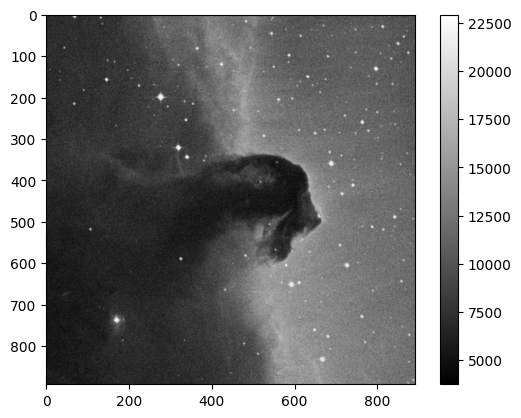

In [10]:
plt.imshow(image_data, cmap='gray')
plt.colorbar()

# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

Let's get some basic statistics about our image:

In [11]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 3759
Max: 22918
Mean: 9831.481676287574
Stdev: 3032.3927542049046


### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, we'll need to cast the data from a 2D array to something one dimensional.

In this case, let's use the `ndarray.flatten()` to return a 1D numpy array. Here we use the print statements to check that the "flattened" array is stilly a numpy array, and that the number of entries in the flattened array equals the total number of pixels in the image (that is, 893 x 891 = 795663 pixels total).

In [12]:
print(type(image_data.flatten()))
print(image_data.flatten().shape)

<class 'numpy.ndarray'>
(795663,)


Now make the plot using `matplotlib.pyplot.hist`

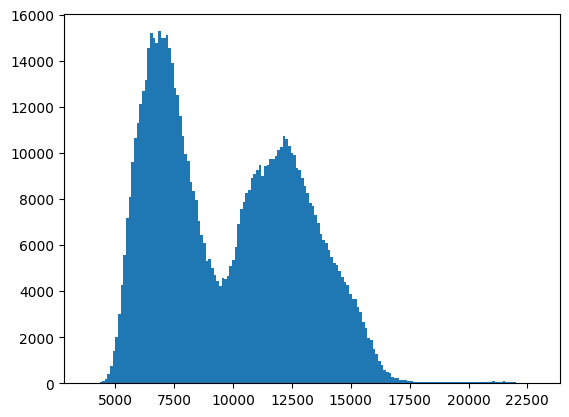

In [13]:
histogram = plt.hist(image_data.flatten(), bins='auto')

### Displaying the image with a logarithmic scale

What if we want to use a logarithmic color scale? To do so, we'll need to load the `LogNorm` object from `matplotlib`.

In [14]:
from matplotlib.colors import LogNorm

[Text(1, 5000.0, '5,000'),
 Text(1, 10000.0, '10,000'),
 Text(1, 20000.0, '20,000')]

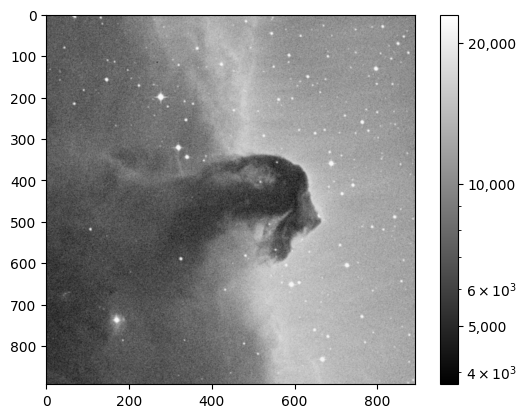

In [15]:
plt.imshow(image_data, cmap='gray', norm=LogNorm())

# I chose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

## Basic image math: image stacking

You can also perform math with the image data like any other numpy array.  In this particular example, we'll stack several images of M13 taken with a ~10'' telescope.

Let's start by opening a series of FITS files and store the data in a list, which we've named `image_concat`.

In [16]:
base_url = 'http://data.astropy.org/tutorials/FITS-images/M13_blue_{0:04d}.fits'

image_list = [download_file(base_url.format(n), cache=True) 
              for n in range(1, 5+1)]
image_concat = [fits.getdata(image) for image in image_list]

Now we'll stack the images by summing the concatenated list.

In [17]:
# The long way
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image

# The short way
# final_image = np.sum(image_concat, axis=0)

We're going to show the image, but need to decide on the best stretch. To do so let's plot a histogram of the data.

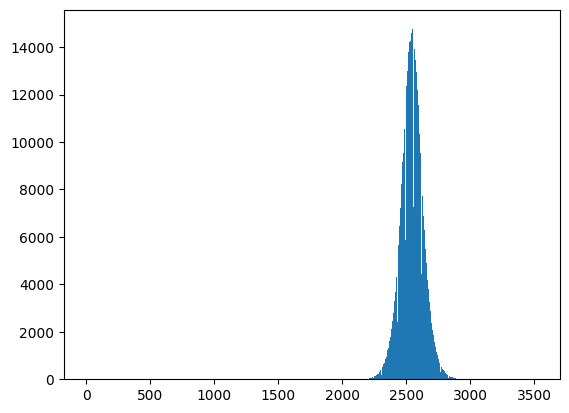

In [18]:
image_hist = plt.hist(final_image.flatten(), bins='auto')

We'll use the keywords `vmin` and `vmax` to set limits on the color scaling for `imshow`. By setting limits according to the histogram above, we are able to generate image with more distinct color distribution.

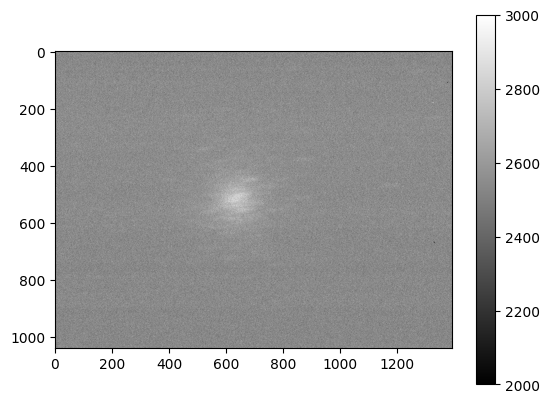

In [19]:
plt.imshow(final_image, cmap='gray', vmin=2E3, vmax=3E3)
plt.colorbar()

## Writing image data to a FITS file

We can do this with the `writeto()` method.

Warning: you'll receive an error if the file you are trying to write already exists.  That's why we've set `overwrite=True`.

In [20]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, overwrite=True)

## Exercises

Determine the mean, median, and standard deviation of the stacked M13 image data.  Add corresponding keywords 'MEAN', 'MEDIAN', and 'STANDARD DEVIATION' to the primary HDU in the output file you just wrote to, and store the statistics you calculated in keywords created in the header. See the [Editing a FITS Header tutorial](https://learn.astropy.org/tutorials/FITS-header.html) to learn how to add the keywords. 

Show the image of the Horsehead Nebula, but in units of *surface brightness* (magnitudes per square arcsecond).
(Hint: the *physical* size of the image is 15x15 arcminutes.) For the Horsehead Nebula image used in this tutorial, assume that the magnitude is just the value stored in each pixel.

Now write out the image you just created, preserving the header the original image had, but add a keyword 'UNITS' with the value 'mag per sq arcsec'.
(Hint: it may be helpful to read the [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html) documentation if you're not sure how to include both the header and the data.)